<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Pipeline/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results collection

This notebook collects and presents the results of the experiments.

## Preliminaries

In [2]:
# Parameters for results calculation.
n_bootstrap = 100   # Number of bootstrapped samples to take.

# Selecting which models to display a ROC curve for.
roc_datasets = ['fishClips']
roc_frameSelections = ['motionAbsdiff_10']
roc_models = ['dinov2-vitg14-clf']
roc_imageSizes = [448]
roc_classifiers = ['ShallowNetwork']
roc_valScores = ['roc-auc']

In [3]:
# Specifying directories where the results are stored.
parameters_drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Parameters'    # Best model parameters
predictions_drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Predictions'  # Predictions for test set

In [4]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Copy results to runtime.
parameters_dir = '/content/Parameters'
predictions_dir = '/content/Predictions'

import shutil

shutil.copytree(parameters_drive_dir, parameters_dir)
shutil.copytree(predictions_drive_dir, predictions_dir)

'/content/Predictions'

In [6]:
# Functions to process results

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import resample

def bootstrap_metrics(data, threshold, n_bootstrap=100, sample_size=50):
    """
    Calculation of performance metrics based on bootstrapped test samples.
    :param: data: a dataframe containing predictions.
                  Must contain columns 'prediction' and 'label'.
    :param: threshold: the threshold to use for positive predictions.
    :param: n_bootstrap: the number of bootstrapping rounds.
    :param: sample_size: the size of one bootstrapped sample.
    :return: a dictionary containing the accuracy, recall, precision and their standard deviations.
    """
    accuracy_scores = []
    recall_scores = []
    precision_scores = []

    for _ in range(n_bootstrap):
        # Resample the data with replacement
        sample = resample(data, n_samples=sample_size)

        # Convert probabilities to binary predictions based on threshold
        predictions = (sample['prediction'] >= threshold).astype(int)
        true_values = sample['label']

        # Calculate metrics
        accuracy_scores.append(accuracy_score(true_values, predictions))
        recall_scores.append(recall_score(true_values, predictions))
        precision_scores.append(precision_score(true_values, predictions, zero_division=0))

    return {
        'accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
        'recall': (np.mean(recall_scores), np.std(recall_scores)),
        'precision': (np.mean(precision_scores), np.std(precision_scores))
    }

In [7]:
# Dictionaries for later ease of use.
dataset_dict = {'fishClips' : 'Fish clips', 'AK-fish' : 'AK fish'}
frameSelection_dict = {'evenly' : 'Evenly spaced', 'motionAbsdiff' : 'Motion based'}
dino_dict = {'dinov2-vits14' : 'ViT-S/14', 'dinov2-vitg14' : 'ViT-G/14'}

## AR results

Comparing the performance of our model on the AR task with the baseline model MSQNet

In [8]:
import os

results = []

for pred_file in os.listdir(predictions_dir):

  # Consider only prediction outputs files.
  if pred_file.startswith('pred'):
    predictions = pd.read_csv(f'{predictions_dir}/{pred_file}')

  else:
    continue

  # Read the setup of the experiment.
  properties = pred_file.split('_')

  dataset = dataset_dict[properties[1]]
  frameSelection = frameSelection_dict[properties[2]]

  model_name = '-'.join(properties[4].split('-')[:2])
  dino_model = dino_dict[model_name]

  # Read threshold for positive predictions.
  params_file = pred_file.replace('pred_', 'params_')
  parameters = pd.read_csv(f'{parameters_dir}/{params_file}')

  pos_threshold = parameters['pos_threshold'][0]

  # Set size of one bootstrapped sample to the size of the prediction set.
  sample_size = len(predictions)

  # Calculate performance metrics based on bootstrapped sample.
  metrics = bootstrap_metrics(predictions, pos_threshold, n_bootstrap, sample_size)

  results.append({
    'Dataset': dataset,
    'Frame selection' : frameSelection,
    'DINOv2 model' : dino_model,
    'Accuracy': f'{metrics["accuracy"][0] * 100:.2f} +/ {1.96 * metrics["accuracy"][1] * 100:.2f} %',
    'Recall': f'{metrics["recall"][0] * 100:.2f} +/ {1.96 * metrics["recall"][1] * 100:.2f} %',
    'Precision': f'{metrics["precision"][0] * 100:.2f} +/ {1.96 * metrics["precision"][1] * 100:.2f} %',
    })

results_df = pd.DataFrame(results)

In [9]:
# Show the results table.
results_df

,Dataset,Frame selection,DINOv2 model,Accuracy,Recall,Precision
0,Fish clips,Motion based,ViT-G/14,80.29 +/ 10.52 %,0.00 +/ 0.00 %,0.00 +/ 0.00 %
1,AK fish,Motion based,ViT-S/14,82.83 +/ 6.07 %,36.84 +/ 22.74 %,23.58 +/ 15.39 %
2,Fish clips,Motion based,ViT-S/14,79.04 +/ 11.76 %,0.00 +/ 0.00 %,0.00 +/ 0.00 %


In [ ]:
# Save results table to Drive.
drive_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Results/Metrics'

if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

from datetime import datetime
current_date = datetime.now().strftime('%d-%m-%Y')

results_df.to_csv(f'{drive_dir}/AR_results_{current_date}.csv', index=False)

## ROC curve
Display ROC curves for the selected models.

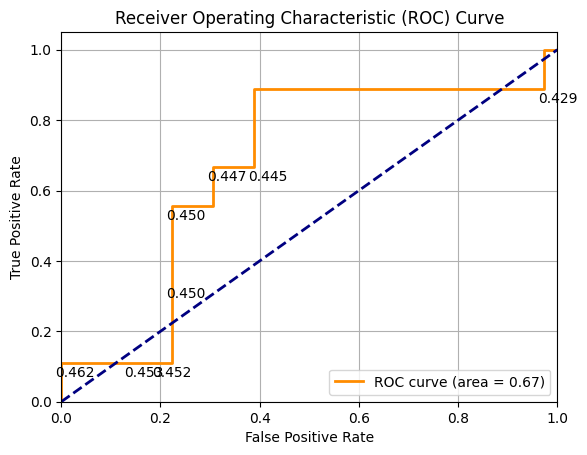

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

for dataset in roc_datasets:
  for frame_selection in roc_frameSelections:
    for model in roc_models:
      for image_size in roc_imageSizes:
        for classifier in roc_classifiers:
          for val_score in roc_valScores:
            pred_file = f'pred_{dataset}_{frame_selection}_{model}_{image_size}_{classifier}_{val_score}.csv'

            pred_data = pd.read_csv(f'{predictions_dir}/{pred_file}')

            predictions = pred_data['prediction']
            true_labels = pred_data['label']

            # Compute the ROC curve values
            fpr, tpr, thresholds = roc_curve(true_labels, predictions)

            # Compute the AUC (Area Under the Curve)
            roc_auc = auc(fpr, tpr)

            # Plot the ROC curve
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line

            # Select a subset of thresholds to annotate for clarity
            thresholds_to_display = np.linspace(0, len(thresholds) - 1, num=10, dtype=int)

            for i in thresholds_to_display[1:-1]:
                plt.annotate(f'{thresholds[i]:.3f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(10,-10), ha='center')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid(True)

            # Save figure to Drive.
            figures_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/Results/Figures/"

            if not os.path.exists(figures_dir):
                os.makedirs(figures_dir)

            figure_path = os.path.join(figures_dir, f'ROC_{dataset}_{frame_selection}_{model}_{image_size}_{classifier}_{val_score}.png')

            plt.savefig(figure_path, dpi=300, bbox_inches='tight')
            plt.show()